<a href="https://colab.research.google.com/github/nitkum41/Machine-Learning/blob/main/LSTM_google_stock_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:

df = pd.read_csv('/content/GOOG.csv')

In [6]:
#Separate dates for future plotting into a series
train_dates = pd.to_datetime(df['Date'])

In [7]:
#Variables for training
cols = list(df)[1:6]

In [13]:
df_for_training = df[cols].astype(float)
print(df_for_training.shape)

(4028, 5)


In [9]:
#Normalization
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [12]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future



for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4014, 14, 5).
trainY shape == (4014, 1).


In [14]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
226/226 [==============================] - 6s 17ms/step - loss: 0.1138 - val_loss: 0.1681
Epoch 2/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0207 - val_loss: 0.0474
Epoch 3/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0194 - val_loss: 0.0439
Epoch 4/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0155 - val_loss: 0.0765
Epoch 5/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0161 - val_loss: 0.1031
Epoch 6/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0144 - val_loss: 0.0814
Epoch 7/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0148 - val_loss: 0.0489
Epoch 8/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0143 - val_loss: 0.0173
Epoch 9/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0149 - val_loss: 0.1658
Epoch 10/10
226/226 [==============================] - 3s 13ms/step - loss: 0.0132 - val_lo

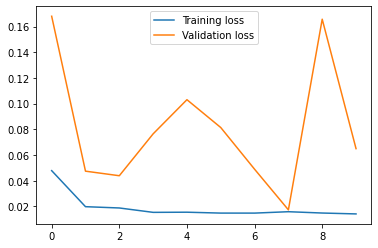

In [16]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [18]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()  #generating future dates

forecast = model.predict(trainX[-n_future:]) #forecast 

In [19]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]  #drop others and retain only the first column

In [21]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())


    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


In [24]:
#plotting the final plot
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


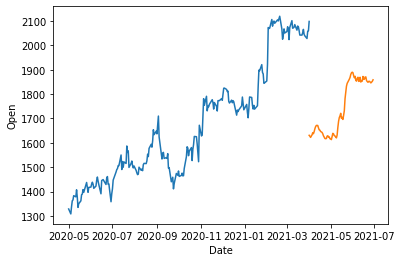

In [25]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])